In [340]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly
import warnings
from utils.data_helper import *
import yfinance as yf
from arch import arch_model
import xgboost as xgb
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
import lightgbm
from catboost import CatBoostRegressor, Pool

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 200

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [375]:
end_date = datetime.today()
start_date = end_date - BDay(500)
symbol = 'SPY'

In [376]:
 # Bug from yahoo API, it doesn't include price at end_date            
forecast = 10

df = yf.download(tickers=symbol, interval="1d",auto_adjust=True, start=start_date, end=end_date)

df['return'] = 100 * df['Close'].pct_change().fillna(0)
df['return'] = 100 * np.log(df['Close'] / df['Close'].shift(1)).fillna(0)

df[f'ret_{forecast}d'] = df['return'].rolling(window=forecast, min_periods=10).mean()
df[f'vol_{forecast}d'] = df['return'].rolling(window=forecast, min_periods=10).std()
df['y'] = df[f'ret_{forecast}d']

[*********************100%***********************]  1 of 1 completed


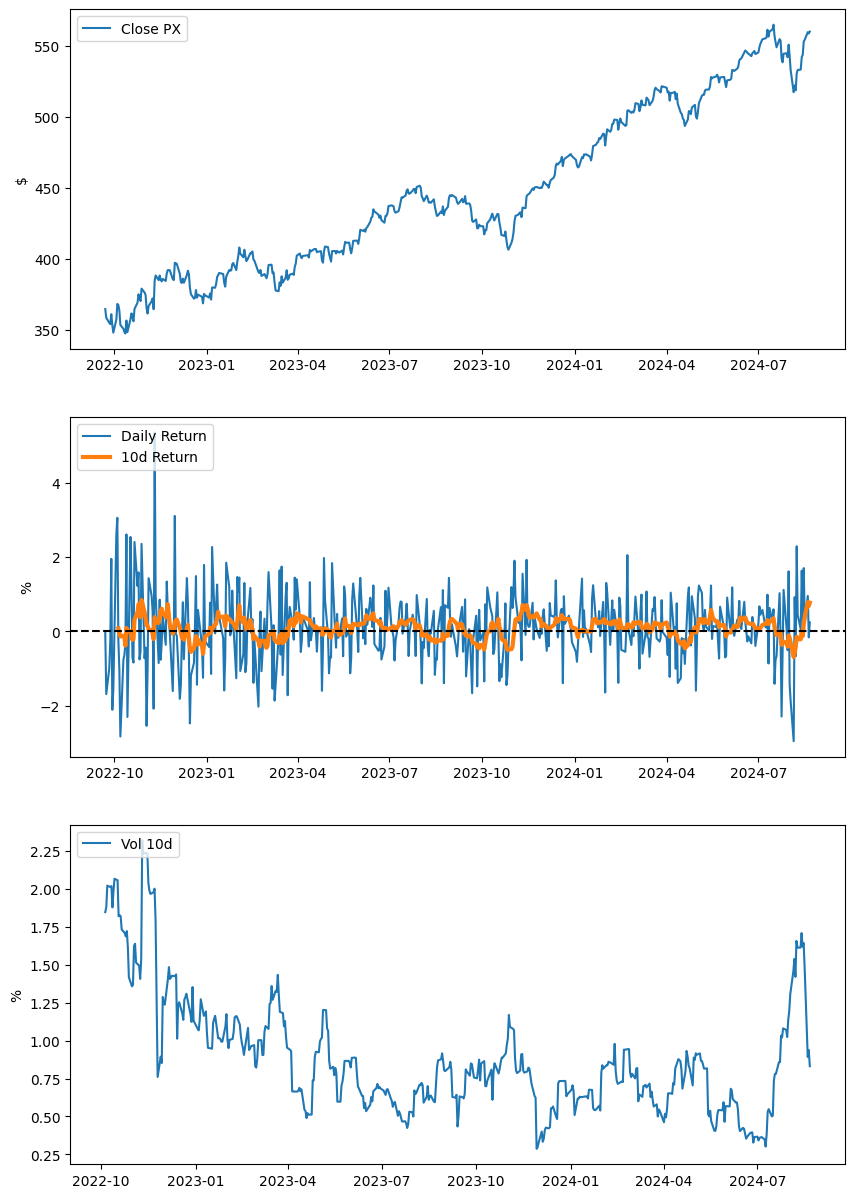

In [378]:
fig, axs = plt.subplots(3,1,figsize=(10,15))

ax = axs[0]
ax.plot(df['Close'], label='Close PX')
ax.set_ylabel('$')
ax.legend(loc='upper left')

ax = axs[1]
ax.plot(df['return'], label='Daily Return')
ax.plot(df[f'ret_{forecast}d'], label=f'{forecast}d Return', linewidth=3)
ax.axhline(0, color='black', linestyle='--')
ax.set_ylabel('%')
ax.legend(loc='upper left')

ax = axs[2]
ax.plot(df[f'vol_{forecast}d'], label=f'Vol {forecast}d')
ax.set_ylabel('%')
ax.legend(loc='upper left')

In [379]:
def create_features(df):
    dfml = df.copy()
    dfml['dayofweek'] = dfml.index.to_series().dt.day_of_week
    dfml['quarter'] = dfml.index.to_series().dt.quarter
    dfml['month'] = dfml.index.to_series().dt.month
    dfml['year'] = dfml.index.to_series().dt.year
    dfml['dayofyear'] = dfml.index.to_series().dt.day_of_year
    dfml['dayofmonth'] = dfml.index.to_series().dt.day

    dfml['vol_prev1'] = dfml[f'vol_{forecast}d'].shift(1)
    dfml['vol_prev5'] = dfml[f'vol_{forecast}d'].shift(5)
    dfml['vol_prev10'] = dfml[f'vol_{forecast}d'].shift(10)

    dfml['ret_prev1'] = dfml[f'ret_{forecast}d'].shift(1)
    dfml['ret_prev5'] = dfml[f'ret_{forecast}d'].shift(5)
    dfml['ret_prev10'] = dfml[f'ret_{forecast}d'].shift(10)

    dfml['o1'] = dfml['Open'].shift(1)
    dfml['o5'] = dfml['Open'].shift(5)
    dfml['o10'] = dfml['Open'].shift(10)

    dfml['c1'] = dfml['Close'].shift(1)
    dfml['c5'] = dfml['Close'].shift(5)
    dfml['c10'] = dfml['Close'].shift(10)

    dfml['v1'] = dfml['Volume'].shift(1)
    dfml['v5'] = dfml['Volume'].shift(5)
    dfml['v10'] = dfml['Volume'].shift(10)

    dfml = dfml.fillna(method='ffill')
    dfml = dfml.fillna(0)

    return dfml

# Linear Regression

In [380]:
dfml = create_features(df)
X = dfml.drop(columns=['y'])
y = dfml['y'].shift(-forecast).fillna(0)

# rolling tranings
model = LinearRegression()
train_days = forecast*10
res_vals = []
res_dts = []

iter_start = train_days+forecast
iter_end = len(dfml)-forecast

with tqdm(total = iter_end-iter_start) as pbar:
    for i in range(iter_start, iter_end):        

        # train data needs to be shifted by forcast day because the label does not exist
        tx = X.iloc[i-forecast-train_days+1:i-forecast+1]
        ty = y.iloc[i-forecast-train_days+1:i-forecast+1]        

        model.fit(tx, ty)        

        pred_x = X.iloc[i]
        pred_y = model.predict([pred_x])[0]
        pred_y = min(pred_y,4)
        pred_y = max(pred_y,-4)

        pred_dt = X.iloc[i+forecast].name

        res_vals.append(pred_y)
        res_dts.append(pred_dt)                
        pbar.update(1)       

pred_linear = pd.Series(res_vals, index=res_dts)


100%|██████████| 361/361 [00:00<00:00, 968.60it/s]


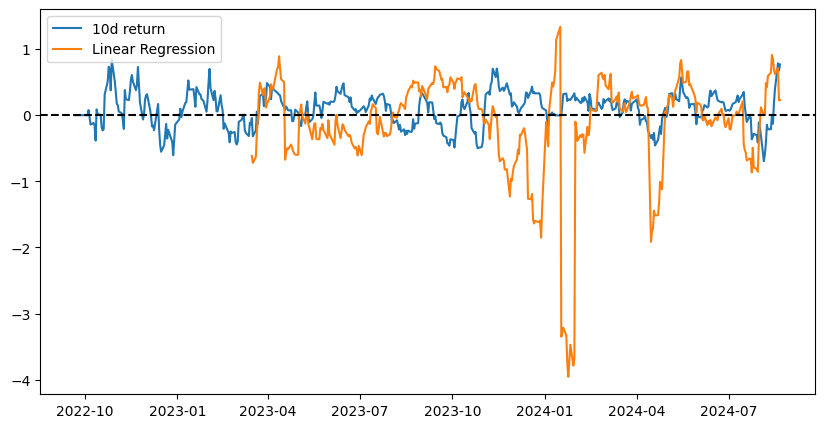

In [381]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
ax.plot(dfml['y'], label=f'{forecast}d return')
ax.plot(pred_linear, label=f'Linear Regression')
ax.axhline(0, color='black', linestyle='--')
ax.legend(loc='upper left')

# ARIMA

In [382]:
# rolling trainings
train_days = forecast*5
pred_arr = []
iter_start = train_days
iter_end = len(dfml)-forecast+1

with tqdm(total=iter_end-iter_start) as pbar:
    for i in range(iter_start, iter_end):    
        ty = df['y'].iloc[i-train_days:i]
        fdate = dfml.iloc[i+forecast-1].name  

        model = sm.tsa.ARIMA(ty, order=(1,1,1))  # (p,d,q)
        pred_y = model.fit().forecast(steps=forecast).iloc[-1]        
        pred_y = pd.Series(pred_y, index=[fdate])

        pred_arr.append(pred_y)
        pbar.update(1)        

pred_arima = pd.concat(pred_arr)

100%|██████████| 422/422 [00:09<00:00, 44.35it/s]


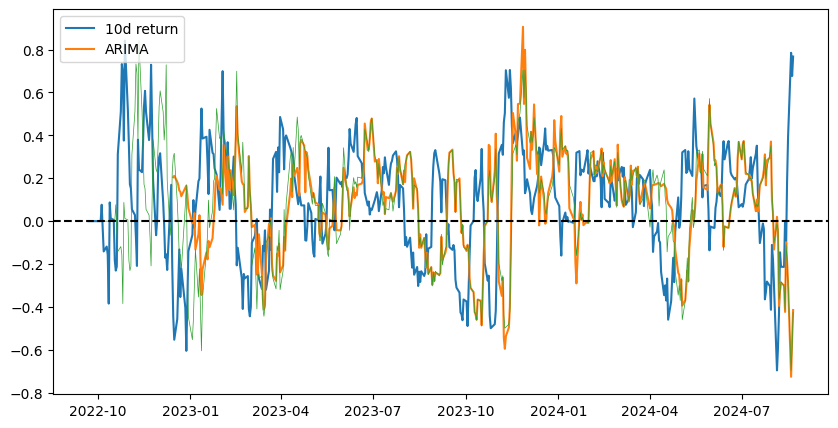

In [383]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
ax.plot(dfml['y'], label=f'{forecast}d return')
ax.plot(pred_arima, label=f'ARIMA')
ax.plot(dfml['y'].shift(forecast), linewidth=0.5)
ax.axhline(0, color='black', linestyle='--')
ax.legend(loc='upper left')

# XGB

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

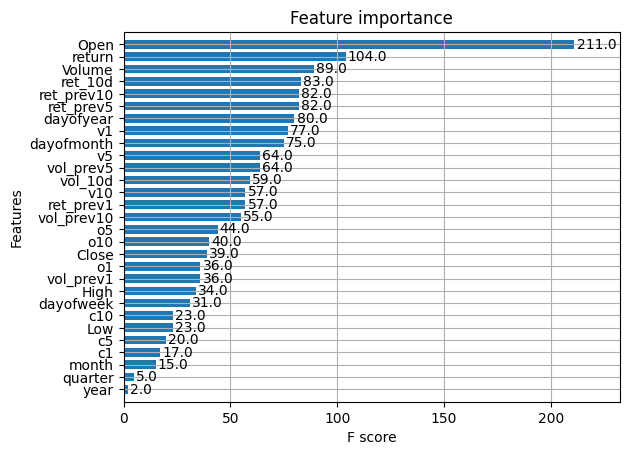

In [384]:
dfml = create_features(df)

X = dfml.drop(columns=['y'])
y = dfml['y'].shift(-forecast).fillna(0)

train_cutoff = int(len(df)*0.7)
X_train, y_train = X[:train_cutoff], y[:train_cutoff]
X_test, y_test = X[train_cutoff:], y[train_cutoff:]

#Defining and fitting the model
model = xgb.XGBRegressor(n_estimators=50,early_stopping_rounds=50)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

#Plot of feature importance
xgb.plot_importance(model, height=0.7)

In [385]:
# rolling tranings
model = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50)
train_days = forecast*3
res_vals = []
res_dts = []

iter_start = train_days+forecast
iter_end = len(dfml)-forecast

with tqdm(total = iter_end-iter_start) as pbar:
    for i in range(iter_start, iter_end):        

        # train data needs to be shifted by forcast day because the label does not exist
        tx = X.iloc[i-forecast-train_days+1:i-forecast+1]
        ty = y.iloc[i-forecast-train_days+1:i-forecast+1]        

        model.fit(tx, ty, eval_set=[(tx, ty)], verbose=False)        

        pred_x = X.iloc[i]
        pred_y = model.predict([pred_x])[0]
        pred_dt = X.iloc[i+forecast].name

        res_vals.append(pred_y)
        res_dts.append(pred_dt)                
        pbar.update(1)       

pred_xgb = pd.Series(res_vals, index=res_dts)

100%|██████████| 431/431 [00:30<00:00, 14.03it/s]


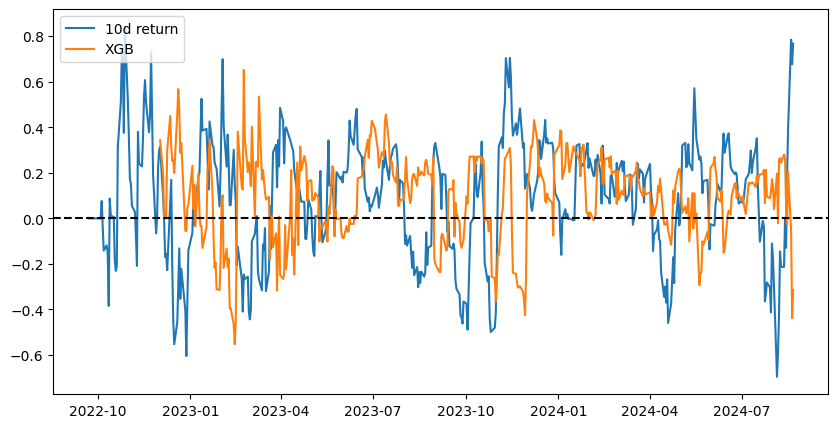

In [386]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
ax.plot(dfml['y'], label=f'{forecast}d return')
ax.plot(pred_xgb, label=f'XGB')
#ax.plot(dfml['y'].shift(forecast), linewidth=0.5)
ax.axhline(0, color='black', linestyle='--')
ax.legend(loc='upper left')

# Suppert Vector Regression

In [387]:
# rolling tranings
dfml = create_features(df)
X = dfml.drop(columns=['y'])
y = dfml['y'].shift(-forecast).fillna(0)

model = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
train_days = forecast * 1

res_vals = []
res_dts = []

iter_start = train_days+forecast
iter_end = len(dfml)-forecast

with tqdm(total = iter_end-iter_start) as pbar:
    for i in range(iter_start, iter_end):        

        # train data needs to be shifted by forcast day because the label does not exist
        tx = X.iloc[i-forecast-train_days+1:i-forecast+1]
        ty = y.iloc[i-forecast-train_days+1:i-forecast+1]        

        model.fit(tx, ty)        

        pred_x = X.iloc[i]
        pred_y = model.predict([pred_x])[0]
        pred_dt = X.iloc[i+forecast].name

        res_vals.append(pred_y)
        res_dts.append(pred_dt)                
        pbar.update(1)        

pred_svr = pd.Series(res_vals, index=res_dts)

100%|██████████| 451/451 [00:00<00:00, 1275.62it/s]


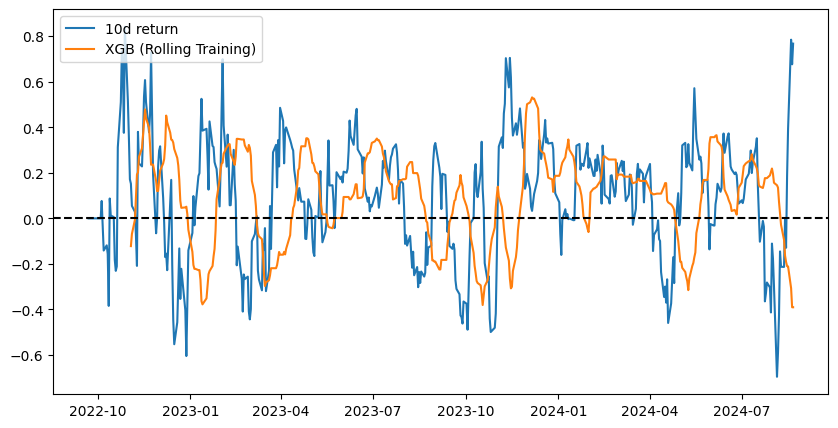

In [388]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
ax.plot(dfml['y'], label=f'{forecast}d return')
ax.plot(pred_svr, label=f'XGB (Rolling Training)')
#ax.plot(dfml['y'].shift(forecast), label=f'{forecast}d return')
ax.axhline(0, color='black', linestyle='--')
ax.legend(loc='upper left')

# LGBMRegressor

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

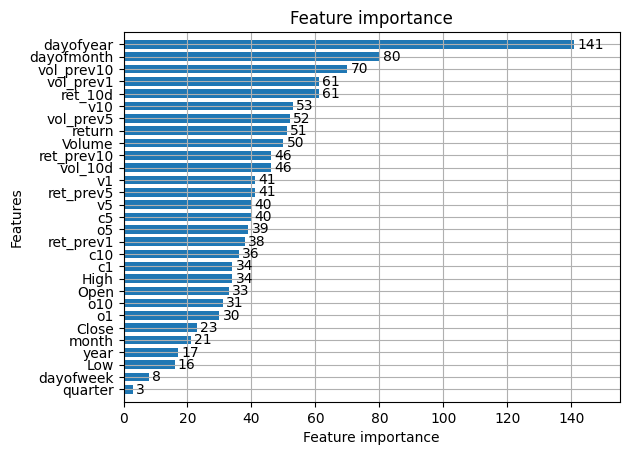

In [389]:
dfml = create_features(df)

X = dfml.drop(columns=['y'])
y = dfml['y'].shift(-forecast).fillna(0)

train_cutoff = int(len(df)*0.7)
X_train, y_train = X[:train_cutoff], y[:train_cutoff]
X_test, y_test = X[train_cutoff:], y[train_cutoff:]

#Defining and fitting the model
model = LGBMRegressor(random_state=123, verbosity=-1)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

#Plot of feature importance
lightgbm.plot_importance(model, height=0.7)

In [390]:
# rolling tranings
dfml = create_features(df)
X = dfml.drop(columns=['y'])
y = dfml['y'].shift(-forecast).fillna(0)

model = LGBMRegressor(random_state=123, verbosity=-1)
train_days = forecast * 5

res_vals = []
res_dts = []

iter_start = train_days+forecast
iter_end = len(dfml)-forecast

with tqdm(total = iter_end-iter_start) as pbar:
    for i in range(iter_start, iter_end):        

        # train data needs to be shifted by forcast day because the label does not exist
        tx = X.iloc[i-forecast-train_days+1:i-forecast+1]
        ty = y.iloc[i-forecast-train_days+1:i-forecast+1]        

        model.fit(tx, ty, eval_set=(tx,ty))        

        pred_x = X.iloc[i]
        pred_y = model.predict([pred_x])[0]
        pred_dt = X.iloc[i+forecast].name

        res_vals.append(pred_y)
        res_dts.append(pred_dt)                
        pbar.update(1)        

pred_lgbm = pd.Series(res_vals, index=res_dts)

100%|██████████| 411/411 [00:08<00:00, 48.00it/s]


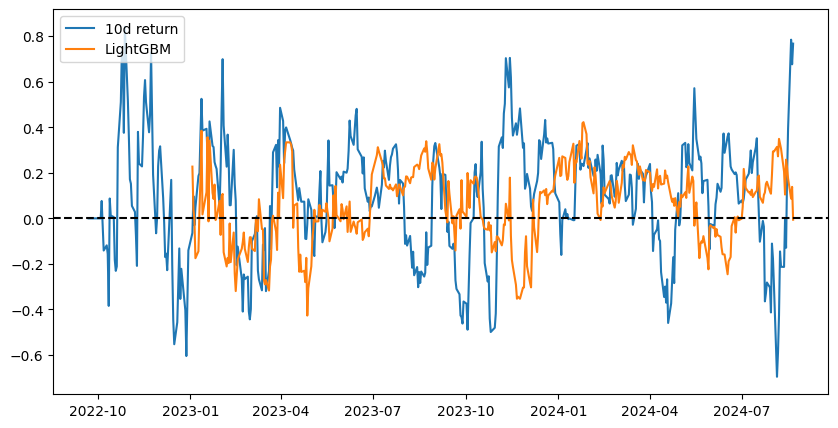

In [391]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
ax.plot(dfml['y'], label=f'{forecast}d return')
ax.plot(pred_lgbm, label=f'LightGBM')
ax.axhline(0, color='black', linestyle='--')
ax.legend(loc='upper left')

# CatBoost

In [392]:
# rolling tranings
dfml = create_features(df)
X = dfml.drop(columns=['y'])
y = dfml['y'].shift(-forecast).fillna(0)

model = CatBoostRegressor(iterations=100, random_state=42)
train_days = forecast * 5

res_vals = []
res_dts = []

iter_start = train_days+forecast
iter_end = len(dfml)-forecast

with tqdm(total = iter_end-iter_start) as pbar:
    for i in range(iter_start, iter_end):        

        # train data needs to be shifted by forcast day because the label does not exist
        tx = X.iloc[i-forecast-train_days+1:i-forecast+1]
        ty = y.iloc[i-forecast-train_days+1:i-forecast+1]        

        train_pool = Pool(tx, label=ty, timestamp=[int(tx.index[0].value/1e9) for x in list(tx.index)])
        model.fit(train_pool, verbose=False, eval_set=train_pool, early_stopping_rounds=10)        

        pred_x = X.iloc[i]
        pred_y = model.predict([pred_x])[0]
        pred_dt = X.iloc[i+forecast].name

        res_vals.append(pred_y)
        res_dts.append(pred_dt)                
        pbar.update(1)        

pred_cat = pd.Series(res_vals, index=res_dts)

100%|██████████| 411/411 [00:16<00:00, 24.31it/s]


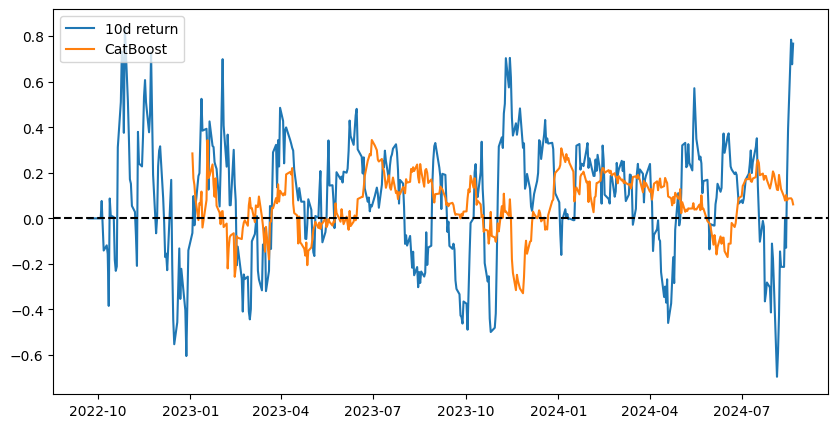

In [393]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
ax.plot(dfml['y'], label=f'{forecast}d return')
ax.plot(pred_cat, label='CatBoost')
ax.axhline(0, color='black', linestyle='--')
ax.legend(loc='upper left')

# Autoregressive Forecast with Random Forest

In [394]:
dfml = df.copy()
dfml['y'] = dfml['y'].fillna(0)

model = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 6)
model.fit(y=dfml['y'])
model.get_feature_importances()


,feature,importance
0,lag_1,0.823123
5,lag_6,0.043367
2,lag_3,0.036284
1,lag_2,0.035286
4,lag_5,0.031183
3,lag_4,0.030756


In [395]:
# rolling trainings
train_days = forecast*3
pred_arr = []
iter_start = train_days
iter_end = len(dfml)-forecast+1

model = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 6)

with tqdm(total=iter_end-iter_start) as pbar:
    for i in range(iter_start, iter_end):    
        ty = dfml['y'].iloc[i-train_days:i]
        fdate = dfml.iloc[i+forecast-1].name  
        
        model.fit(y=ty)        

        pred_y = model.predict(steps=forecast).iloc[-1]
        pred_y = pd.Series(pred_y, index=[fdate])

        pred_arr.append(pred_y)
        pbar.update(1)        

pred_af_rf = pd.concat(pred_arr)

100%|██████████| 442/442 [00:27<00:00, 16.22it/s]


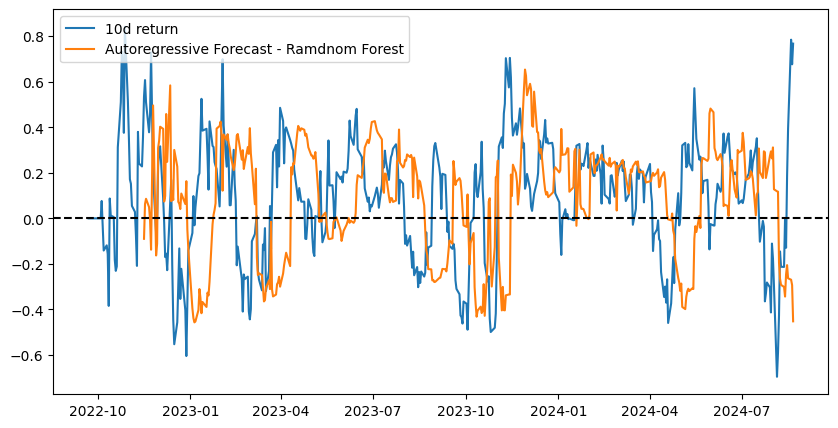

In [396]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
ax.plot(dfml['y'], label=f'{forecast}d return')
ax.plot(pred_af_rf, label=f'Autoregressive Forecast - Ramdnom Forest')
ax.axhline(0, color='black', linestyle='--')
ax.legend(loc='upper left')

# Autoregessive Forecast with LightGBM

In [397]:
dfml = df.copy()
dfml['y'] = dfml['y'].fillna(0)

model = ForecasterAutoreg(regressor = LGBMRegressor(random_state=123, verbosity=-1),lags = 6)
model.fit(y=dfml['y'])
model.get_feature_importances()

,feature,importance
0,lag_1,385
5,lag_6,345
1,lag_2,280
4,lag_5,279
3,lag_4,264
2,lag_3,230


In [398]:
# rolling trainings
train_days = forecast*5
pred_arr = []
iter_start = train_days
iter_end = len(dfml)-forecast+1

model = ForecasterAutoreg(regressor = LGBMRegressor(random_state=123, verbosity=-1),lags = 5)

with tqdm(total=iter_end-iter_start) as pbar:
    for i in range(iter_start, iter_end):    
        ty = dfml['y'].iloc[i-train_days:i]
        fdate = dfml.iloc[i+forecast-1].name          
        model.fit(y=ty)        
        pred_y = model.predict(steps=forecast).iloc[-1]
        pred_y = pd.Series(pred_y, index=[fdate])
        pred_arr.append(pred_y)
        pbar.update(1)        

pred_af_lgbm = pd.concat(pred_arr)

100%|██████████| 422/422 [00:08<00:00, 51.53it/s]


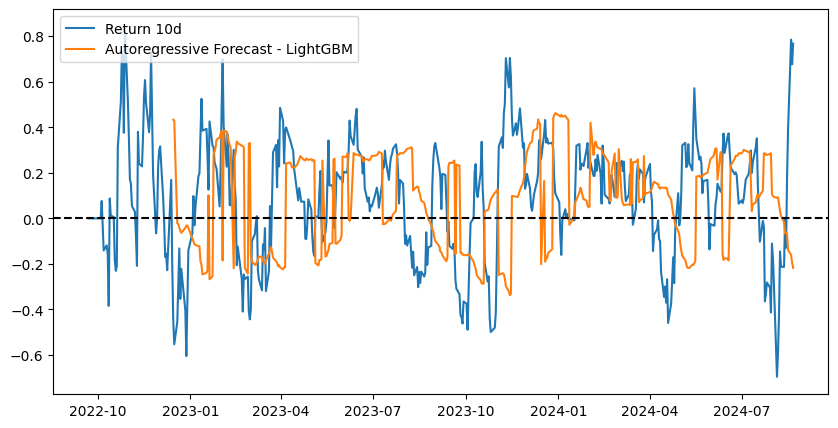

In [399]:
fig, axs = plt.subplots(1,1,figsize=(10,5))
ax = axs
ax.plot(dfml['y'], label=f'Return 10d')
ax.plot(pred_af_lgbm, label=f'Autoregressive Forecast - LightGBM')
ax.axhline(0, color='black', linestyle='--')
ax.legend(loc='upper left')

# Summary

In [405]:
# Custom function to calculate Directional Accuracy
def directional_accuracy(actual_values, predicted_values):        
    #correct_directions = sum((actual_values[i] * predicted_values[i]) > 0 for i in range(1, len(actual_values)))
    correct_directions = sum((actual_values[i] - actual_values[i-1]) * (predicted_values[i] - predicted_values[i-1]) > 0 for i in range(1, len(actual_values)))
    total_predictions = len(actual_values) - 1  # Total number of predictions (excluding the first one)    
    da = correct_directions / total_predictions if total_predictions > 0 else 0
    return da

def sign_accuracy(actual_values, predicted_values):            
    correct_directions = sum(actual_values[i] * predicted_values[i] > 0 for i in range(1, len(actual_values)))
    total_predictions = len(actual_values) - 1  # Total number of predictions (excluding the first one)    
    da = correct_directions / total_predictions if total_predictions > 0 else 0
    return da


def summary_table(actual, lastn, models):
    res = []
    for model in models:         
        res.append([
            model[0],
            mean_squared_error(actual[-lastn:], model[1][-lastn:], squared=False),
            mean_absolute_percentage_error(actual[-lastn:], model[1][-lastn:]),
            directional_accuracy(actual[-lastn:].values, model[1][-lastn:].values),
            sign_accuracy(actual[-lastn:].values, model[1][-lastn:].values)
        ])

    res = pd.DataFrame(res, columns=['model', 'rmse', 'mape', 'directional_acc', 'sign_acc'])
    return res

In [406]:
summary_table(df['y'], 300, [
    ['Rolling', df['y'].shift(forecast)],
    ['LinearReg', pred_linear],
    ['ARIMA', pred_arima],
    ['XGB', pred_xgb],
    ['SVR', pred_svr],    
    ['LGBM', pred_lgbm],
    ['CatBoost', pred_cat],
    ['AutoReg Random Forest', pred_af_rf],
    ['AutoReg LightGBM', pred_af_lgbm],
])

,model,rmse,mape,directional_acc,sign_acc
0,Rolling,0.370670,8.491401,0.324415,0.612040
1,LinearReg,0.935325,30.421636,0.595318,0.414716
2,ARIMA,0.378623,6.593688,0.351171,0.598662
3,XGB,0.307623,7.746435,0.488294,0.628763
4,SVR,0.337157,8.643804,0.344482,0.581940
5,LGBM,0.316671,6.898775,0.471572,0.535117
6,CatBoost,0.297115,6.778841,0.478261,0.595318
7,AutoReg Random Forest,0.362855,6.705949,0.408027,0.622074
8,AutoReg LightGBM,0.345646,4.103230,0.424749,0.541806
